In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import xgboost as xgb


In [31]:
data = pd.read_csv('Student_performance_data.csv')
feature_cols = ['ParentalSupport', 'ParentalEducation', 'Age', 'Gender', 'Ethnicity']
post_treatment_feature_cols = ['Volunteering', 'Music', 'Extracurricular', 'Tutoring', 'Absences', 'StudyTimeWeekly']
treatment_col  = 'Sports'
outcome_col = 'GradeClass'
X = data[feature_cols] 
T = data[treatment_col]
Y = data[outcome_col]

treated_locations = T == 1
control_locations = T == 0

# print treated and control group sizes
print(f'Treated group size: {T.sum()}')
print(f'Control group size: {len(T) - T.sum()}')

# print grade distribution for treated and control groups
print('Grade distribution for treated group:')
print(Y[T == 1].value_counts(normalize=True))

print('Grade distribution for control group:')
print(Y[T == 0].value_counts(normalize=True))

Treated group size: 726
Control group size: 1666
Grade distribution for treated group:
GradeClass
4.0    0.495868
3.0    0.173554
2.0    0.151515
1.0    0.126722
0.0    0.052342
Name: proportion, dtype: float64
Grade distribution for control group:
GradeClass
4.0    0.510804
3.0    0.172869
2.0    0.168667
1.0    0.106242
0.0    0.041417
Name: proportion, dtype: float64


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

def calculate_propensity_scores(X, T, rf_model=True):
    if rf_model:
        rf_model = RandomForestClassifier(n_estimators=3, random_state=42)
        rf_model.fit(X, T)
        propensity_scores = rf_model.predict_proba(X)[:, 1]
        return propensity_scores
    else:
        # Scale the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        log_reg = LogisticRegression(max_iter=10000)
        log_reg.fit(X, T)
        propensity_scores = log_reg.predict_proba(X)[:, 1]
        return propensity_scores

def calculate_and_plot_calibration(propensity_scores_data, T):
    # Calculate Brier Score
    brier_score = brier_score_loss(T, propensity_scores_data)
    print(f'Brier Score: {brier_score:.2f}')

    # Generate Calibration Curve
    prob_true, prob_pred = calibration_curve(T, propensity_scores_data, n_bins=10)

    # Plot Calibration Curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot (Reliability Diagram)')
    plt.legend()
    plt.show()

def overlap_propensity_graph(treated_scores, control_scores):
    # Create histograms
    plt.hist(control_scores, bins=30, color='red', alpha=0.5, label='Control')
    plt.hist(treated_scores, bins=30, color='blue', alpha=0.5, label='Treated')

    # Labels and legend
    plt.xlabel('Propensity Score')
    plt.ylabel('Number of Units')
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

# Example of Training and Evaluating on a Test Set
def train_and_evaluate_propensity_model(X, T, rf_model=True):
    # Split data into train and test sets
    X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.3, random_state=42)

    # Calculate propensity scores using training set
    propensity_scores_train = calculate_propensity_scores(X_train, T_train, rf_model=rf_model)
    

    # Calculate and plot calibration for the train set
    print("Train Set Calibration:")
    calculate_and_plot_calibration(propensity_scores_train, T_train)

    # Calculate propensity scores using the test set
    propensity_scores_test = calculate_propensity_scores(X_test, T_test, rf_model=rf_model)

    # Calculate and plot calibration for the test set
    print("Test Set Calibration:")
    calculate_and_plot_calibration(propensity_scores_test, T_test) 
    
    propensity_scores_train = pd.Series(propensity_scores_train, index=X_train.index)
    propensity_scores_test = pd.Series(propensity_scores_test, index=X_test.index)
    propensity_scores = pd.concat([propensity_scores_train, propensity_scores_test])
    
    # overlap graph
    overlap_propensity_graph(propensity_scores[T == 1], propensity_scores[T == 0])
    return propensity_scores



Train Set Calibration:
Brier Score: 0.17


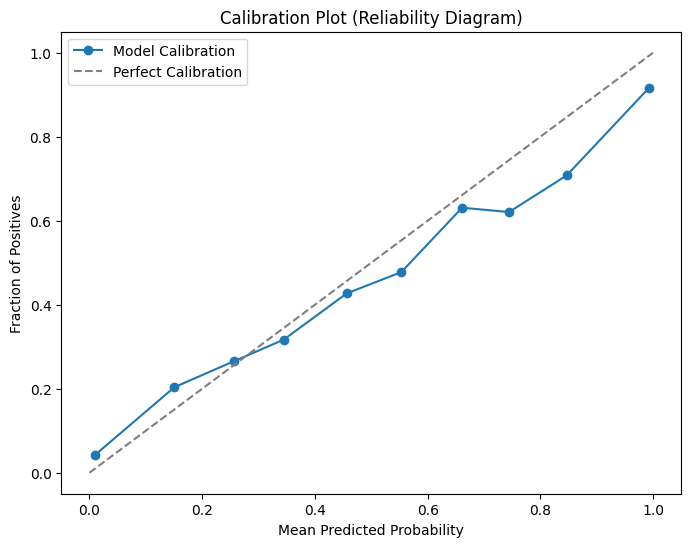

Test Set Calibration:
Brier Score: 0.14


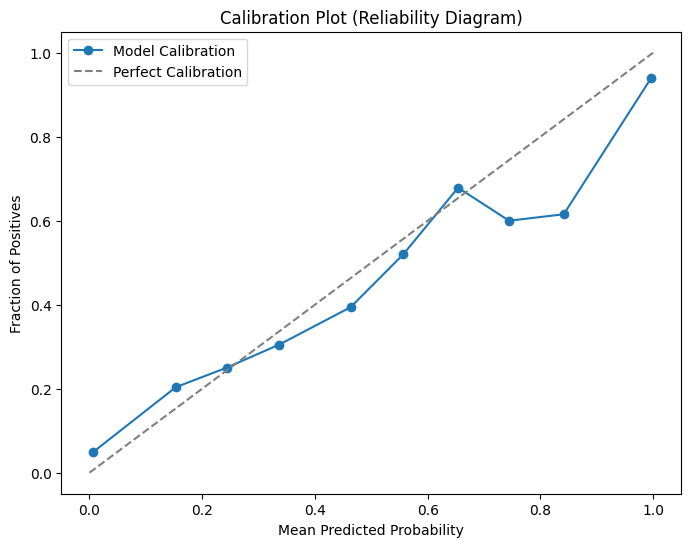

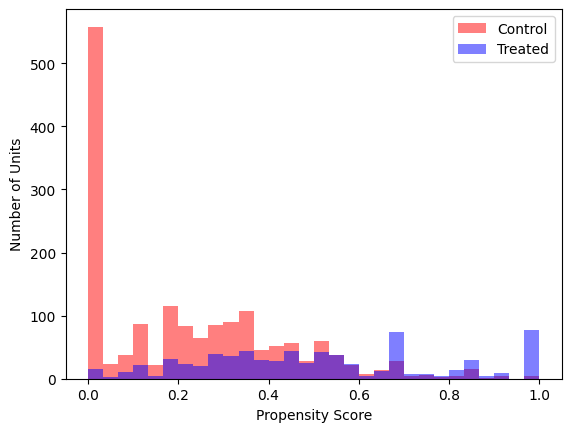

In [34]:
propensity_scores = train_and_evaluate_propensity_model(X, T, rf_model=True)
# TODO: note - run also in rf_model=False
propensity_scores = np.clip(propensity_scores, 0.01, 0.99)
sample_weights = T / propensity_scores + (1 - T) / (1 - propensity_scores)
sample_weights = np.nan_to_num(sample_weights, nan=1.0, posinf=1.0, neginf=1.0)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import xgboost as xgb

# Function to estimate ATT and ATE using S-learner with Random Forest or XGBoost
def estimate_att_and_ate_s_learner(T, Y, X, sample_weights=None, is_rf_model=True, n_bootstrap=1000, ci=95):
    # Concatenate treatment indicator to covariates
    X_T = pd.concat([X, T.rename('T')], axis=1)

    # Store results for bootstrap estimates
    ate_estimates = []
    att_estimates = []
    train_rmse_values = []
    val_rmse_values = []

    for _ in range(n_bootstrap):
        # Bootstrap resampling
        indices = np.random.choice(len(X_T), size=len(X_T), replace=True)
        X_T_resample = X_T.iloc[indices]
        Y_resample = Y.iloc[indices]
        T_resample = T.iloc[indices]

        # Split into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_T_resample, Y_resample, test_size=0.3, random_state=42)

        # Clip the propensity scores to avoid 0 and 1 values
        if sample_weights is not None:
            sample_weights_train = sample_weights[X_train.index]
        else:
            sample_weights_train = None

        if is_rf_model:
            # Define a Random Forest model optimized for small datasets
            model = RandomForestRegressor(
                n_estimators=50,
                max_depth=5,
                min_samples_split=5,
                min_samples_leaf=3,
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            )
        else:
            # Define an XGBoost Regressor for small datasets
            model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.5,
                colsample_bytree=0.5,
                random_state=42,
                n_jobs=-1
            )

        # Train the model on the training data
        model.fit(X_train, Y_train, sample_weight=sample_weights_train)

        # Calculate predictions for treated and control scenarios
        X_T_1 = pd.concat([X, pd.Series(np.ones(len(X)), name='T')], axis=1)  # Data with T = 1
        X_T_0 = pd.concat([X, pd.Series(np.zeros(len(X)), name='T')], axis=1)  # Data with T = 0

        # Predict outcomes under treated and control scenarios
        Y1_pred = model.predict(X_T_1)
        Y0_pred = model.predict(X_T_0)

        # Calculate ATT for the treated group (treated - control for treated individuals)
        att_s_learner = np.mean(Y1_pred[T_resample == 1] - Y0_pred[T_resample == 1])
        att_estimates.append(att_s_learner)

        # Calculate Average Treatment Effect (ATE) for the entire population
        ate_s_learner = np.mean(Y1_pred - Y0_pred)
        ate_estimates.append(ate_s_learner)

        # Calculate RMSE for this run and store the values
        train_rmse = np.sqrt(np.mean((Y_train - model.predict(X_train))**2))
        val_rmse = np.sqrt(np.mean((Y_val - model.predict(X_val))**2))
        train_rmse_values.append(train_rmse)
        val_rmse_values.append(val_rmse)

    # Compute confidence intervals
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    ate_ci = np.percentile(ate_estimates, [lower_percentile, upper_percentile])
    att_ci = np.percentile(att_estimates, [lower_percentile, upper_percentile])

    # Calculate the mean RMSE across all bootstrap runs
    mean_train_rmse = np.mean(train_rmse_values)
    mean_val_rmse = np.mean(val_rmse_values)

    # Print results
    print(f'Mean Training RMSE: {mean_train_rmse:.2f}')
    print(f'Mean Validation RMSE: {mean_val_rmse:.2f}')
    print(f'Average Treatment Effect (ATE): {ate_s_learner:.2f} (95% CI: {ate_ci})')
    print(f'Average Treatment Effect for Treated (ATT): {att_s_learner:.2f} (95% CI: {att_ci})')

    return ate_ci, att_ci, mean_train_rmse, mean_val_rmse


In [36]:
# Estimate ATT using the S-Learner
estimate_att_and_ate_s_learner(T, Y, X, sample_weights=sample_weights, is_rf_model=True)
print()
estimate_att_and_ate_s_learner(T, Y, X, is_rf_model=True)
print()
estimate_att_and_ate_s_learner(T, Y, X, sample_weights=sample_weights, is_rf_model=False)
print()
estimate_att_and_ate_s_learner(T, Y, X, is_rf_model=False)
# TODO: note: the use of sample weights (propensity scores) for the model, is something worth mentioning we tried, also it doesnt seem to make a big difference from some reason
# TODO: note: rmse 1 means that in average we miss by one grade
# TODO: note: due the fact that the data is small and that both models get to similiar result after a lot of hyperparameter tuning, we can assume this is the best result we can get

Mean Training RMSE: 1.19
Mean Validation RMSE: 1.22
Average Treatment Effect (ATE): -0.07 (95% CI: [-0.22575853  0.06563217])
Average Treatment Effect for Treated (ATT): -0.06 (95% CI: [-0.223668    0.06598354])
Mean Training RMSE: 1.18
Mean Validation RMSE: 1.21
Average Treatment Effect (ATE): -0.01 (95% CI: [-0.1610139   0.04334061])
Average Treatment Effect for Treated (ATT): -0.01 (95% CI: [-0.16182193  0.03988571])
Mean Training RMSE: 1.12
Mean Validation RMSE: 1.22
Average Treatment Effect (ATE): -0.08 (95% CI: [-0.24008092  0.05487079])
Average Treatment Effect for Treated (ATT): -0.09 (95% CI: [-0.24083353  0.05967112])
Mean Training RMSE: 1.09
Mean Validation RMSE: 1.20
Average Treatment Effect (ATE): -0.07 (95% CI: [-0.21180208  0.05675607])
Average Treatment Effect for Treated (ATT): -0.08 (95% CI: [-0.20695274  0.05466428])


(array([-0.21180208,  0.05675607]),
 array([-0.20695274,  0.05466428]),
 1.0878603854583189,
 1.1962108864334653)

In [37]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Function to estimate ATT and ATE using T-Learner with Random Forest or XGBoost
def estimate_att_and_ate_t_learner(T, Y, X, is_rf_model=True, n_bootstrap=1000, ci=95):

    # Store results for bootstrap estimates
    att_estimates = []
    ate_estimates = []
    train_rmse_treated_values = []
    train_rmse_control_values = []
    val_rmse_treated_values = []
    val_rmse_control_values = []

    for _ in range(n_bootstrap):
        # Bootstrap resampling
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_resample = X.iloc[indices]
        Y_resample = Y.iloc[indices]
        T_resample = T.iloc[indices]

        # Split into training and validation sets
        X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(X_resample, Y_resample, T_resample, test_size=0.3, random_state=42)

        if is_rf_model:
            # Define separate Random Forest models for treated and control groups
            model_treated = RandomForestRegressor(
                n_estimators=100,
                max_depth=6,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            )
            model_control = RandomForestRegressor(
                n_estimators=100,
                max_depth=6,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            )
        else:
            # Define separate XGBoost models for treated and control groups
            model_treated = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.5,
                colsample_bytree=0.5,
                random_state=42,
                n_jobs=-1
            )
            model_control = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.5,
                colsample_bytree=0.5,
                random_state=42,
                n_jobs=-1
            )

        # Train models separately on treated and control groups
        model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1])
        model_control.fit(X_train[T_train == 0], Y_train[T_train == 0])

        # Predict outcomes for the whole dataset using both models
        Y1_pred = model_treated.predict(X)  # Predicted outcomes if treated
        Y0_pred = model_control.predict(X)  # Predicted outcomes if control

        # Calculate ATT for the treated group (treated - control for treated individuals)
        att_t_learner = np.mean(Y1_pred[T == 1] - Y0_pred[T == 1])
        att_estimates.append(att_t_learner)

        # Calculate Average Treatment Effect (ATE) for the entire population
        ate_t_learner = np.mean(Y1_pred - Y0_pred)
        ate_estimates.append(ate_t_learner)

        # Calculate RMSE for this run and store the values
        train_rmse_treated = np.sqrt(np.mean((Y_train[T_train == 1] - model_treated.predict(X_train[T_train == 1]))**2))
        train_rmse_control = np.sqrt(np.mean((Y_train[T_train == 0] - model_control.predict(X_train[T_train == 0]))**2))
        val_rmse_treated = np.sqrt(np.mean((Y_val[T_val == 1] - model_treated.predict(X_val[T_val == 1]))**2))
        val_rmse_control = np.sqrt(np.mean((Y_val[T_val == 0] - model_control.predict(X_val[T_val == 0]))**2))

        # Append the RMSE values for this bootstrap run
        train_rmse_treated_values.append(train_rmse_treated)
        train_rmse_control_values.append(train_rmse_control)
        val_rmse_treated_values.append(val_rmse_treated)
        val_rmse_control_values.append(val_rmse_control)

    # Compute confidence intervals
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    ate_ci = np.percentile(ate_estimates, [lower_percentile, upper_percentile])
    att_ci = np.percentile(att_estimates, [lower_percentile, upper_percentile])

    # Calculate the mean RMSE across all bootstrap runs
    mean_train_rmse_treated = np.mean(train_rmse_treated_values)
    mean_train_rmse_control = np.mean(train_rmse_control_values)
    mean_val_rmse_treated = np.mean(val_rmse_treated_values)
    mean_val_rmse_control = np.mean(val_rmse_control_values)

    # Print results
    print(f'Mean Training RMSE (Treated): {mean_train_rmse_treated:.2f}')
    print(f'Mean Training RMSE (Control): {mean_train_rmse_control:.2f}')
    print(f'Mean Validation RMSE (Treated): {mean_val_rmse_treated:.2f}')
    print(f'Mean Validation RMSE (Control): {mean_val_rmse_control:.2f}')
    print(f'Average Treatment Effect (ATE): {ate_t_learner:.2f} (95% CI: {ate_ci})')
    print(f'Average Treatment Effect for Treated (ATT): {att_t_learner:.2f} (95% CI: {att_ci})')

    return att_ci, ate_ci, mean_train_rmse_treated, mean_train_rmse_control, mean_val_rmse_treated, mean_val_rmse_control


In [38]:
# Estimate ATT using the T-Learner
estimate_att_and_ate_t_learner(T, Y, X, is_rf_model=True)
print()
estimate_att_and_ate_t_learner(T, Y, X, is_rf_model=False)


Mean Training RMSE (Treated): 1.11
Mean Training RMSE (Control): 1.10
Mean Validation RMSE (Treated): 1.23
Mean Validation RMSE (Control): 1.17
Average Treatment Effect (ATE): -0.12 (95% CI: [-0.20494714  0.04133588])
Average Treatment Effect for Treated (ATT): -0.12 (95% CI: [-0.19202197  0.05319487])
Mean Training RMSE (Treated): 1.10
Mean Training RMSE (Control): 1.13
Mean Validation RMSE (Treated): 1.24
Mean Validation RMSE (Control): 1.20
Average Treatment Effect (ATE): -0.02 (95% CI: [-0.2220758   0.04978464])
Average Treatment Effect for Treated (ATT): -0.03 (95% CI: [-0.21224916  0.06711857])


(array([-0.21224916,  0.06711857]),
 array([-0.2220758 ,  0.04978464]),
 1.1026109492605267,
 1.1301856127624013,
 1.2441889799053283,
 1.1967272233861361)

In [39]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Function to estimate ATT using Matching with Bootstrapping
def estimate_att_matching(T, Y, X, n_bootstrap=1000, ci=95):
    att_estimates = []
    rmse_values = []

    for _ in range(n_bootstrap):
        # Bootstrap resampling
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_resample = X.iloc[indices]
        Y_resample = Y.iloc[indices]
        T_resample = T.iloc[indices]

        # Perform nearest neighbor matching
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_resample[T_resample == 0])
        distances, indices = nn.kneighbors(X_resample[T_resample == 1])
        matched_outcomes = Y_resample[T_resample == 0].values[indices].flatten()

        # Calculate ATT for this bootstrap sample
        att_matching = np.mean(Y_resample[T_resample == 1].values - matched_outcomes)
        att_estimates.append(att_matching)

        # Calculate RMSE for the matched outcomes
        actual_outcomes = Y_resample[T_resample == 1].values
        rmse = np.sqrt(np.mean((actual_outcomes - matched_outcomes)**2))
        rmse_values.append(rmse)

    # Compute confidence interval for ATT
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    att_ci = np.percentile(att_estimates, [lower_percentile, upper_percentile])

    # Calculate mean RMSE across all bootstrap samples
    mean_rmse = np.mean(rmse_values)

    # Print results
    print(f'Mean RMSE: {mean_rmse:.2f}')
    print(f'Average Treatment Effect for Treated (ATT): {np.mean(att_estimates):.2f} (95% CI: {att_ci})')

    return att_ci, mean_rmse


In [40]:
# Estimate ATT using Matching
estimate_att_matching(T, Y, X)

Mean RMSE: 1.75
Average Treatment Effect for Treated (ATT): -0.06 (95% CI: [-0.25039758  0.13002479])


(array([-0.25039758,  0.13002479]), 1.745120854060342)

In [41]:
import numpy as np

# Function to estimate ATT and ATE using Inverse Probability Weighting (IPW) with Bootstrapping
def estimate_ipw_att_ate(T, Y, weights, n_bootstrap=1000, ci=95):
    att_estimates = []
    ate_estimates = []
    rmse_values = []

    for _ in range(n_bootstrap):
        # Bootstrap resampling
        indices = np.random.choice(len(T), size=len(T), replace=True)
        T_resample = T.iloc[indices]
        Y_resample = Y.iloc[indices]
        weights_resample = weights.iloc[indices]

        # Step 3: Calculate weighted average outcomes
        # Weighted outcome for the treated group
        weighted_outcome_treated = np.sum(weights_resample[T_resample == 1] * Y_resample[T_resample == 1]) / np.sum(weights_resample[T_resample == 1])

        # Weighted outcome for the control group
        weighted_outcome_control = np.sum(weights_resample[T_resample == 0] * Y_resample[T_resample == 0]) / np.sum(weights_resample[T_resample == 0])

        # Step 4: Calculate ATT and ATE
        att_ipw = weighted_outcome_treated - np.mean(Y_resample[T_resample == 0])
        ate_ipw = weighted_outcome_treated - weighted_outcome_control

        att_estimates.append(att_ipw)
        ate_estimates.append(ate_ipw)

        # Calculate RMSE for this bootstrap sample
        actual_outcomes_control = Y_resample[T_resample == 0]
        predicted_outcomes_control = np.full_like(actual_outcomes_control, weighted_outcome_control)
        rmse = np.sqrt(np.mean((actual_outcomes_control - predicted_outcomes_control)**2))
        rmse_values.append(rmse)

    # Compute confidence intervals for ATT and ATE
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    att_ci = np.percentile(att_estimates, [lower_percentile, upper_percentile])
    ate_ci = np.percentile(ate_estimates, [lower_percentile, upper_percentile])

    # Calculate mean RMSE across all bootstrap samples
    mean_rmse = np.mean(rmse_values)

    # Print results
    print(f'Mean RMSE: {mean_rmse:.2f}')
    print(f'Average Treatment Effect (ATE): {np.mean(ate_estimates):.2f} (95% CI: {ate_ci})')
    print(f'Average Treatment Effect for Treated (ATT): {np.mean(att_estimates):.2f} (95% CI: {att_ci})')

    return att_ci, ate_ci, mean_rmse


In [42]:

estimate_ipw_att_ate(T, Y, pd.Series(sample_weights))

Mean RMSE: 1.22
Average Treatment Effect (ATE): -0.09 (95% CI: [-0.435479    0.23104185])
Average Treatment Effect for Treated (ATT): -0.11 (95% CI: [-0.42343764  0.1653483 ])


(array([-0.42343764,  0.1653483 ]),
 array([-0.435479  ,  0.23104185]),
 1.2178595326849655)

In [43]:
# try best model with post treatment features
for feature in post_treatment_feature_cols:
    new_X = pd.concat([X, data[feature]], axis=1)
    print("Feature: ", feature)
    estimate_att_and_ate_s_learner(T, Y, new_X, is_rf_model=True)
    print()
    
    

Feature:  Volunteering
Mean Training RMSE: 1.18
Mean Validation RMSE: 1.21
Average Treatment Effect (ATE): -0.03 (95% CI: [-0.15497935  0.03345865])
Average Treatment Effect for Treated (ATT): -0.03 (95% CI: [-0.15619607  0.03313911])

Feature:  Music
Mean Training RMSE: 1.17
Mean Validation RMSE: 1.21
Average Treatment Effect (ATE): 0.02 (95% CI: [-0.16694544  0.04056021])
Average Treatment Effect for Treated (ATT): 0.03 (95% CI: [-0.16606954  0.04025846])

Feature:  Extracurricular
Mean Training RMSE: 1.17
Mean Validation RMSE: 1.20
Average Treatment Effect (ATE): -0.00 (95% CI: [-0.16433679  0.03406435])
Average Treatment Effect for Treated (ATT): 0.00 (95% CI: [-0.16087432  0.03504951])

Feature:  Tutoring
Mean Training RMSE: 1.17
Mean Validation RMSE: 1.20
Average Treatment Effect (ATE): -0.09 (95% CI: [-0.14072364  0.03542764])
Average Treatment Effect for Treated (ATT): -0.09 (95% CI: [-0.13981536  0.03570656])

Feature:  Absences
Mean Training RMSE: 0.76
Mean Validation RMSE: 0

In [44]:
# TODO: can note: we didnt saw a reason to try double robust estimator because we try a lot of methods (including the ones that are used in the double robust estimator) and we got very similiar results